In [2]:
using Revise
using RadiativeTransfer
using RadiativeTransfer.PhaseFunction
using RadiativeTransfer.RTM
using Distributions

"Generate aerosol optical properties"

# Wavelength (just one for now)
λ = 0.770       # Incident wavelength
depol = 0.0
# Truncation 
Ltrunc = 72             # Truncation  
truncation_type   = PhaseFunction.δBGE(Ltrunc, 2.0)

# polarization_type
polarization_type = Stokes_IQUV()

# Quadrature points for RTM
Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, 60.0, [0.0, 15.0, 30., 45., 60.])

# Aerosol particle distribution and properties
μ            = [0.3] #[0.3,2.0]       # Log mean radius
σ            = [2.0] #[2.0,1.8]       # Log stddev of radius
r_max        = [30.0] #[30.0,30.0]     # Maximum radius
nquad_radius = [2500] #[2500,2500]     # Number of quadrature points for integrating of size dist.
nᵣ           = [1.3] #[1.3, 1.66]     # Real part of refractive index
nᵢ           = [0.001] #[0.001,0.0003]  # Imag part of refractive index

#Aerosol vertical distribution profiles
p₀          = [50000.] #[50000., 20000.] # Pressure peak [Pa]
σp          = [5000.]   #[5000., 2000.]   # Pressure peak width [Pa]

size_distribution = [LogNormal(log(μ[1]), log(σ[1]))] #[LogNormal(log(μ[1]), log(σ[1])), LogNormal(log(μ[2]), log(σ[2]))]

# Create the aerosols (needs to be generalized through loops):
aero1 = make_univariate_aerosol(size_distribution[1], r_max[1], nquad_radius[1], nᵣ[1], nᵢ[1])
#aero2 = make_univariate_aerosol(size_distribution[2], r_max[2], nquad_radius[2], nᵣ[2], nᵢ[2])

# Define some details, run aerosol optics
model_NAI2_aero1 = make_mie_model(NAI2(), aero1, λ, polarization_type, truncation_type)
aerosol_optics_NAI2_aero1 = compute_aerosol_optical_properties(model_NAI2_aero1);
# Truncate:
aerosol_optics_trunc_aero1 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero1)

# Define some details, run aerosol optics
#model_NAI2_aero2 = make_mie_model(NAI2(), aero2, λ, polarization_type, truncation_type)
#aerosol_optics_NAI2_aero2 = compute_aerosol_optical_properties(model_NAI2_aero2);
# Truncate:
#aerosol_optics_trunc_aero2 = PhaseFunction.truncate_phase(truncation_type, aerosol_optics_NAI2_aero2)

# Rayleigh Greek
GreekRayleigh = PhaseFunction.get_greek_rayleigh(depol)


┌ Info: Precompiling RadiativeTransfer [ace8185b-fa20-42f5-912d-1e850dbe6a09]
└ @ Base loading.jl:1278
┌ Info: Fraction of size distribution cut by max radius: 1.5279000287193867e-9 %
└ @ RadiativeTransfer.PhaseFunction /Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/PhaseFunction/mie_helper_functions.jl:264
Computing PhaseFunctions Siewert NAI-2 style ...100%|███| Time: 0:00:02


GreekCoefs{Float64}([0.0, 0.0, 3.0], [1.0, 0.0, 0.5], [0.0, 0.0, 1.224744871391589], [0.0, 1.5, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

In [3]:
vza = [60., 45., 30., 15., 0., 15., 30., 45., 60.]
vaz = [180., 180., 180., 180., 0., 0., 0., 0., 0.]
sza = 60.
Nquad, qp_μ, wt_μ = rt_set_streams(RTM.RadauQuad(), Ltrunc, sza, vza);

In [4]:
" Atmospheric Profiles, basics, needs to be refactore entirely"
file = "/Users/sanghavi/GDrive/code/github/atm_profiles/MERRA300.prod.assim.inst6_3d_ana_Nv.20150613.hdf.nc4"   
timeIndex = 2 # There is 00, 06, 12 and 18 in UTC, i.e. 6 hourly data stacked together

# What latitude do we want? 
myLat = 34.1377;
myLon = -118.1253;

# Read profile (and generate dry/wet VCDs per layer)
profile_caltech = RTM.read_atmos_profile(file, myLat, myLon, timeIndex);

# Compute layer optical thickness for Rayleigh (surface pressure in hPa) 
τRayl =  RTM.getRayleighLayerOptProp(profile_caltech.psurf/100, λ, depol, profile_caltech.vcd_dry);
ϖRayl = ones(length(τRayl))

#Compute Naer aerosol optical thickness profiles
τAer_1 = RTM.getAerosolLayerOptProp(1.0, p₀[1], σp[1], profile_caltech.p_levels)
#τAer_2 = RTM.getAerosolLayerOptProp(0.3, p₀[2], σp[2], profile_caltech.p_levels)

# Can be done with arbitrary length later:
τAer = 0*τAer_1 #[τAer_1 τAer_2]
@show sum(τAer_1)#, sum(τAer_2)
ϖAer = [aerosol_optics_NAI2_aero1.ω̃] #[aerosol_optics_NAI2_aero1.ω̃ aerosol_optics_NAI2_aero2.ω̃];
fᵗ   = [aerosol_optics_trunc_aero1.fᵗ] #[aerosol_optics_trunc_aero1.fᵗ aerosol_optics_trunc_aero2.fᵗ];


sum(τAer_1) = 0.9999999999999998


In [32]:
(τAer[10,:])
profile_caltech.p_levels[73]

96885.4375

In [7]:
m = 0
RaylZ⁺⁺, RaylZ⁻⁺     = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, GreekRayleigh, m);
aero1_Z⁺⁺, aero1_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero1.greek_coefs, m);
#aero2_Z⁺⁺, aero2_Z⁻⁺ = PhaseFunction.compute_Z_moments(polarization_type, qp_μ, aerosol_optics_trunc_aero2.greek_coefs, m);
aerosol_optics = [aerosol_optics_trunc_aero1] #[aerosol_optics_trunc_aero1 aerosol_optics_trunc_aero2]
Aer𝐙⁺⁺ = [aero1_Z⁺⁺] #[aero1_Z⁺⁺, aero2_Z⁺⁺];
Aer𝐙⁻⁺ = [aero1_Z⁻⁺] #[aero1_Z⁻⁺, aero2_Z⁻⁺];
@show size(τAer[1])
iz = 10
τ, ϖ, Z⁺⁺, Z⁻⁺  = RTM.construct_atm_layer(τRayl[iz], τAer[iz,:], ϖRayl[iz], ϖAer, fᵗ, RaylZ⁺⁺, RaylZ⁻⁺, Aer𝐙⁺⁺, Aer𝐙⁻⁺)
@show τ, ϖ
@show τAer[iz], τRayl[iz]

size(τAer[1]) = ()
(τ, ϖ) = (2.126814916654541e-6, 1.0)
(τAer[iz], τRayl[iz]) = (0.0, 2.126814916654541e-6)


(0.0, 2.126814916654541e-6)

In [18]:
R,T = RTM.run_RTM(polarization_type, sza, vza, vaz, τRayl,ϖRayl, τAer, ϖAer, fᵗ, qp_μ, wt_μ, 3, aerosol_optics, GreekRayleigh)

m = 0
m = 1
m = 2


([0.017769361714252013 -0.00012333012709995865 0.0 0.0; 0.012192557177473704 0.00037066266245840834 0.0 0.0; … ; 0.006908421049048571 0.005654798790883541 0.0 0.0; 0.011342174243081832 0.00630385734407023 0.0 0.0], [1305.53784628902 0.0064269025175145164 0.0 0.0; 0.0068220958110431894 0.005756728199349869 0.0 0.0; … ; 0.012283443465024012 0.00029538054536904727 0.0 0.0; 6527.6509170239715 -0.00021560369722104476 0.0 0.0])

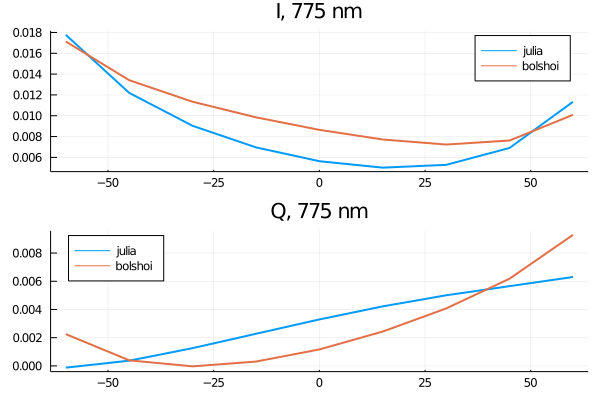

In [28]:
using Plots
using DelimitedFiles
S1=readdlm("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/Rayl_orig.dat", ' ')
vza=[-60. -45. -30. -15. 0. 15. 30. 45. 60.]
I_rayl0=S1[:,1]
Q_rayl0=S1[:,2]
U_rayl0=S1[:,3]
V_rayl0=S1[:,4]
p1=plot(vza', [R[:,1], I_rayl0], title="I, 775 nm", label=["julia" "bolshoi"], lw=2, legend=:topright, size = (600, 400))
p2=plot(vza', [R[:,2], Q_rayl0], title="Q, 775 nm", label=["julia" "bolshoi"], lw=2, legend=:topleft, size = (600, 400))
plot(p1, p2, layout=(2, 1))

In [61]:
i = RTM.nearest_point(qp_μ, 0.5)

11

In [89]:
using LinearAlgebra
phi = 180
m=0
cos_m_phi = cosd(m*phi)
sin_m_phi = sind(m*phi)

Diagonal([cos_m_phi, cos_m_phi, sin_m_phi, sin_m_phi])

4×4 Diagonal{Float64,Array{Float64,1}}:
 1.0   ⋅    ⋅    ⋅ 
  ⋅   1.0   ⋅    ⋅ 
  ⋅    ⋅   0.0   ⋅ 
  ⋅    ⋅    ⋅   0.0

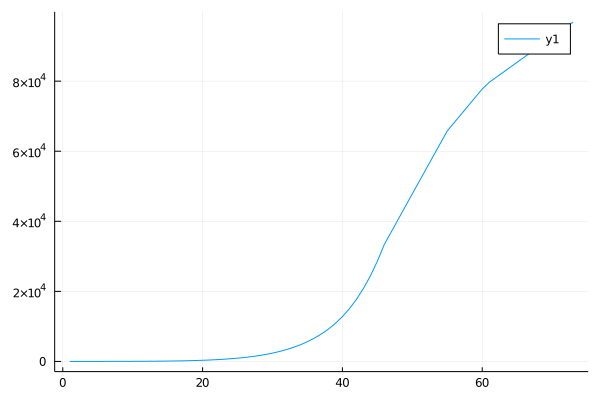

In [33]:
plot(profile_caltech.p_levels)

In [37]:
S1=readdlm("/Users/sanghavi/GDrive/code/github/RadiativeTransfer.jl/src/Notebooks/mon06lat35n.mpi", skipstart=3)

34×35 Array{Any,2}:
 34     ""  ""  60.6    ""   ""     ""   …   ""        ""       5.355e-6
 33     ""  ""  58.6    ""   ""     ""       ""        ""       2.595e-5
 32     ""  ""  56.5    ""   ""     ""       ""        ""       7.791e-5
 31     ""  ""  54.4    ""   ""     ""       ""        ""       7.249e-5
 30     ""  ""  52.2    ""   ""     ""       ""        ""       7.517e-5
 29     ""  ""  50.0    ""   ""     ""   …   ""        ""       7.814e-5
 28     ""  ""  47.7    ""   ""     ""       ""        ""       7.944e-5
 27     ""  ""  45.5    ""   ""     ""       ""        ""       7.601e-5
 26     ""  ""  43.3    ""   ""     ""       ""        ""       6.858e-5
 25     ""  ""  41.1    ""   ""     ""       ""        ""       5.898e-5
 24     ""  ""  39.0    ""   ""     ""   …   ""        ""       4.948e-5
 23     ""  ""  36.9    ""   ""     ""       ""        ""       4.103e-5
 22     ""  ""  34.8    ""   ""     ""       ""        ""       3.693e-5
  ⋮                         ⋮  

In [36]:
z=S1[3:end,2]
p=S1[3:end,3]
plot(p,z)

LoadError: Cannot convert SubString{String} to series data for plotting